# Orbit in a point-mass potential

This example shows how to get the orbit of a tracer particle in a point-mass potential using the streakline module.

First we'll load the required modules and setup the notebook:

In [1]:
from __future__ import print_function, division

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import G

import streakline

%matplotlib inline

mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['font.size'] = 18

Next, let's define our potential by a $1\,\rm M_\odot$ point mass, and put our tracer particle initially at $1\,\rm AU$.

In [2]:
M = 1*u.Msun
x_ = np.array([1, 0, 0])*u.au

Let's also place our tracer on a circular orbit:

In [3]:
vc = np.sqrt(G*M/np.sqrt(np.sum(x_**2)))
vc.to(u.km/u.s)

<Quantity 29.78469182967693 km / s>

In [4]:
v_ = np.array([0, vc.value, 0])*vc.unit

Now that the potential and the initial conditions are set, we need to define a few of the orbital integration parameters. First, we need to set the type of potential, next the integrator, then how long we want to integrate the orbit, with how big time steps, and in which direction (+1 for forward in time, -1 for back in time).

In [5]:
potential_ = 'point'
integrator_ = 'lf'
age = 1*u.yr
dt_ = 1*u.day
sign = 1.

To speed up the calculations in the streakline module, integrator and potential variables are assigned an integer ids, which will be input for the orbit integrator. Here are a couple of helper functions that do the translation.

In [6]:
def get_intid(integrator):
    """Assign integrator ID for a given integrator choice
    Parameter:
    integrator - either 'lf' for leap frog or 'rk' for Runge-Kutta
    """
    
    integrator_dict = {'lf': 0, 'rk': 1}
    
    return integrator_dict[integrator]
            
def get_potid(potential):
    """Assign potential ID for a given potential choice
    Parameter:
    potential - one of the following: 
    'point' -- point mass
    'log' -- triaxial logarithmic halo
    'nfw' -- triaxial NFW halo
    'gal' -- Hernquist bulge + Miyamoto-Nagai disk + triaxial NFW halo
    """
    
    potential_dict = {'point': 0, 'log': 2, 'nfw': 3, 'gal': 4}
    
    return potential_dict[potential]

So far, we've made use of astropy units, which simplifies calculations in python. However, the streakline code is written in c for performance, and expects all inputs in SI units. 

We'll convert the initial position and velocity, as well as the time step and all of the potential parameters to SI. Potential parameters are passed in a list, and for point mass potential it only consists of a point mass value. We get the potential and integrator IDs using the above helper functions, and calculate the number of time steps we want the integrator to make.

In [7]:
x = x_.si.value
v = v_.si.value
params = [M.si.value,]
potential = get_potid(potential_)
integrator = get_intid(integrator_)
N = int(age/dt_)
dt = dt_.si.value

Now we have all the input parameters for the orbit integrator. It is called by ```streakline.orbit(x_init, v_init, potential_params, potential_id, integrator_id, Nsteps, time_step, sign)```. This function returns a $6\times\rm N_{step}$ array, with the orbital evolution of a tracer particle. The columns of the array are: $x$, $y$, $z$, $v_x$, $v_y$, $v_z$ (all in SI). 

In [8]:
orbit_ = streakline.orbit(x, v, params, potential, integrator, N, dt, sign)

orbit = {}
orbit['x'] = orbit_[:3]*u.m
orbit['v'] = orbit_[3:]*u.m/u.s

Let's check how well the integrator does by plotting the numerically integrated orbit (black) and the analytic solution (red). 

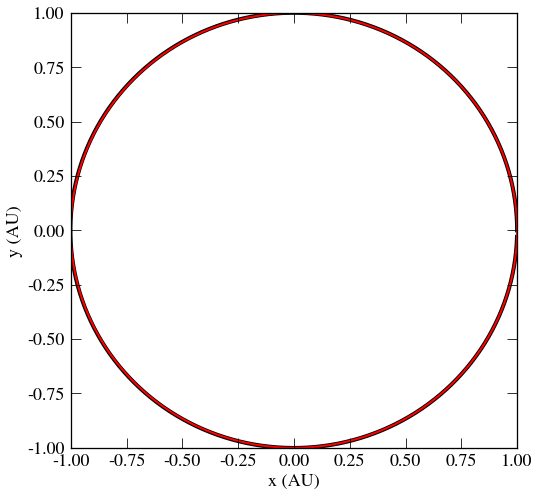

In [9]:
plt.figure()
plt.plot(orbit['x'][0].to(u.au), orbit['x'][1].to(u.au), 'k-', lw=4, zorder=0)
circle = mpl.patches.Circle((0,0), radius=1, lw=2, ec='r', fc='none', zorder=1)
plt.gca().add_artist(circle)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xlabel("x (AU)");
plt.ylabel("y (AU)");

Numerical orbit agrees with the analytic fairly well for this time step size. Explore what happens when you change it!

In [19]:
dt_ = 1*u.hr
N = int(age/dt_)
dt = dt_.si.value
print('{} timesteps'.format(N))
%timeit -n1000 orbit_ = streakline.orbit(x, v, params, potential, integrator, N, dt, sign)

8766 timesteps
1000 loops, best of 3: 220 µs per loop
